# Agent 에 메모리(memory) 추가

현재 챗봇은 과거 상호작용을 스스로 기억할 수 없어 일관된 다중 턴 대화를 진행하는 데 제한이 있습니다. 

이번 튜토리얼에서는 이를 해결하기 위해 **memory** 를 추가합니다.

**참고**

이번에는 pre-built 되어있는 `ToolNode` 와 `tools_condition` 을 활용합니다.

1. [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode): 도구 호출을 위한 노드
2. [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.tools_condition): 도구 호출 여부에 따른 조건 분기


우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 **context**를 기억하지 못합니다. 이는 멀티턴(multi-turn) 대화를 진행하는 능력을 제한합니다.

`LangGraph`는 **persistent checkpointing** 을 통해 이 문제를 해결합니다. 

그래프를 컴파일할 때 `checkpointer`를 제공하고 그래프를 호출할 때 `thread_id`를 제공하면, `LangGraph`는 각 단계 후 **상태를 자동으로 저장** 합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있게 합니다.

**checkpointing** 는 LangChain 의 메모리 기능보다 훨씬 강력합니다. (아마 이 튜토리얼을 완수하면 자연스럽게 이를 확인할 수 있습니다.)

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


하지만 너무 앞서 나가기 전에, 멀티턴(multi-turn) 대화를 가능하게 하기 위해 **checkpointing**을 추가해 보도록 하겠습니다.

`MemorySaver` checkpointer를 생성합니다.

In [3]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

**참고**

이번 튜토리얼에서는 `in-memory checkpointer` 를 사용합니다. 

하지만, 프로덕션 단계에서는 이를 `SqliteSaver` 또는 `PostgresSaver` 로 변경하고 자체 DB에 연결할 수 있습니다. 

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

마지막으로, 제공된 `checkpointer`를 사용하여 그래프를 컴파일합니다.

In [5]:
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

그래프의 연결성은 `LangGraph-Agent` 와 동일합니다.

단지, 이번에 추가된 것은 그래프가 각 노드를 처리하면서 `State`를 체크포인트하는 것뿐입니다.

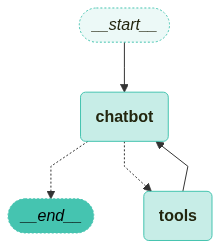

In [6]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

## RunnableConfig 설정

`RunnableConfig` 을 정의하고 `recursion_limit` 과 `thread_id` 를 설정합니다.

- `recursion_limit`: 최대 방문할 노드 수. 그 이상은 RecursionError 발생
- `thread_id`: 스레드 ID 설정

`thread_id` 는 대화 세션을 구분하는 데 사용됩니다. 즉, 메모리의 저장은 `thread_id` 에 따라 개별적으로 이루어집니다.

In [7]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

In [8]:
# 첫 질문
question = (
    "내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

반갑습니다, 테디노트님! YouTube 채널을 운영하고 계시다니 멋지네요. 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 언제든지 말씀해 주세요!


In [9]:
# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 테디노트입니다.


이번에는 `RunnableConfig` 의 `thread_id` 를 변경한 뒤, 이전 대화 내용을 기억하고 있는지 물어보겠습니다.

In [10]:
from langchain_core.runnables import RunnableConfig

question = "내 이름이 뭐라고 했지?"

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

죄송하지만, 이전 대화 내용을 기억할 수 없기 때문에 당신의 이름을 알 수 없습니다. 다시 알려주실 수 있나요?


## 스냅샷: 저장된 State 확인

지금까지 두 개의 다른 스레드에서 몇 개의 체크포인트를 만들었습니다. 

`Checkpoint` 에는 현재 상태 값, 해당 구성, 그리고 처리할 `next` 노드가 포함되어 있습니다.

주어진 설정에서 그래프의 `state`를 검사하려면 언제든지 `get_state(config)`를 호출하세요.

In [11]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='3d7e2c69-58af-43fa-a3e4-a4c2fd91c843'),
 AIMessage(content='반갑습니다, 테디노트님! YouTube 채널을 운영하고 계시다니 멋지네요. 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 언제든지 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 118, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bt3809IkeMwlZHn2HdTgidwcKMHb0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d5a1b663-faac-433f-bcb8-2faf12534e33-0', usage_metadata={'input_tokens': 118, 'output_tokens': 58, 'total_tokens': 176, 'input_token_details': {'audio': 0, 'cache_

`snapshot.config` 를 출력하게 설정된 config 정보를 확인할 수 있습니다.

In [12]:
# 설정된 config 정보
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f060597-ac46-6226-8004-2dbd3d270461'}}

`snapshot.value` 를 출력하게 지금까지 저장된 state 값을 확인할 수 있습니다.

In [13]:
# 저장된 값(values)
snapshot.values

{'messages': [HumanMessage(content='내 이름은 `테디노트` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='3d7e2c69-58af-43fa-a3e4-a4c2fd91c843'),
  AIMessage(content='반갑습니다, 테디노트님! YouTube 채널을 운영하고 계시다니 멋지네요. 어떤 주제로 채널을 운영하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 언제든지 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 118, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bt3809IkeMwlZHn2HdTgidwcKMHb0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d5a1b663-faac-433f-bcb8-2faf12534e33-0', usage_metadata={'input_tokens': 118, 'output_tokens': 58, 'total_tokens': 176, 'input_token_details': {'audi

`snapshot.next` 를 출력하여 현재 시점에서 앞으로 찾아갈 **다음 노드를 확인** 할 수 있습니다.

__END__ 에 도달하였기 때문에 다음 노드는 빈 값이 출력됩니다.

In [14]:
# 다음 노드
snapshot.next

()

In [18]:
#snapshot.metadata["writes"]["chatbot"]["messages"][0]

복잡한 구조의 metadata 를 시각화하기 위해 `display_message_tree` 함수를 사용합니다.

In [17]:
import json
print(json.dumps(snapshot.metadata, indent=2, ensure_ascii=False))


{
  "source": "loop",
  "step": 4,
  "parents": {},
  "thread_id": "1"
}


In [16]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    step: 4
    parents: {}
    thread_id: "1"
